In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

import anndata
import sys
import os

from numpy.random import choice
from tqdm import tqdm

sys.path.append('/mnt/md0/yujia/project/github_package/CausalCellInfer/inst/python/')
sys.path.append('/mnt/md0/yujia/project/github_package/CausalCellInfer/inst/python/scaden_py')
from simulation_tape import generate_simulated_data_tape
from simulation_scaden import generate_simulated_data_scaden
from deconvolution import ScadenDeconvolution


In [3]:
sc_data = anndata.read_h5ad("/mnt/md0/yujia/project/github_package/demo/dat/sc_dat/PBMC/pbmcABC6k.h5ad")
sc_data.obs["celltype"] = sc_data.obs["cell_type"].to_list()
sc_data = sc_data[~sc_data.obs['cell_type'].isin(["Megakaryocytes", "Dendritic Cells"])]
# sc_data.obs["celltype"][sc_data.obs["celltype"] == "Dendritic Cells"] = "Unknown"
sc_data_cp = sc_data.copy()
print(sc_data_cp.obs["celltype"].unique())

['CD8 T cells' 'Monocytes' 'CD4 T cells' 'B cells' 'NK cells']


In [4]:
sc_data_pbmc6k = sc_data_cp[sc_data_cp.obs["IID"].isin(["pbmc6k"])]
sc_data_pbmcA = sc_data_cp[sc_data_cp.obs["IID"].isin(["pbmcA"])]
sc_data_pbmcB = sc_data_cp[sc_data_cp.obs["IID"].isin(["pbmcB"])]
sc_data_pbmcC = sc_data_cp[sc_data_cp.obs["IID"].isin(["pbmcC"])]

sc.pp.normalize_total(sc_data_pbmc6k, target_sum=1e6)
sc.pp.normalize_total(sc_data_pbmcA, target_sum=1e6)
sc.pp.normalize_total(sc_data_pbmcB, target_sum=1e6)
sc.pp.normalize_total(sc_data_pbmcC, target_sum=1e6)

sc_data = sc.concat([sc_data_pbmc6k, sc_data_pbmcA, sc_data_pbmcB, sc_data_pbmcC])

In [5]:
print(sc_data.obs["celltype"].unique())

['CD8 T cells' 'Monocytes' 'CD4 T cells' 'B cells' 'NK cells']


In [9]:
common_genes = pd.read_csv("/mnt/md0/yujia/project/github_package/CausalCellInfer/demo/dat/marker_genes/common_genes.csv", index_col=0)

In [12]:
common_genes.index

Index(['NKG7', 'CD3D', 'HLA-DRA', 'LDHB', 'FTL', 'CST3', 'CTSS', 'FTH1',
       'GNLY', 'KLRF1', 'FCER1G', 'CLIC3', 'IFITM2', 'IL2RB', 'TRDC', 'CD79A',
       'MS4A1', 'CD74', 'IGHM', 'S100A6', 'RPS27', 'CD22', 'GZMK', 'CD8B',
       'CTSW', 'DUSP2'],
      dtype='object', name='gene')

In [13]:
test_x_Monaco = pd.read_csv("/mnt/md0/yujia/project/github_package/demo/dat/bulk/PBMC/Monaco/monaco_pbmc.txt", index_col=0, sep="\t").T

common_genes = pd.read_csv("/mnt/md0/yujia/project/github_package/CausalCellInfer/demo/dat/marker_genes/common_genes.csv", index_col=0).index.to_list()
all_genes = pd.read_csv("/mnt/md0/yujia/project/github_package/CausalCellInfer/demo/dat/marker_genes/all_genes.csv", index_col=0).index.to_list()

In [14]:
test_x_Monaco

,DDX11L1,WASH7P,RP11-34P13.7,CICP27,RP11-34P13.15,RP11-34P13.16,RP11-34P13.13,RP11-34P13.9,RP11-34P13.18,AP006222.2,...,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
CYFZ,3.01149,2.621530,1.286230,1.918490,10.14030,7.06324,10.735640,11.37830,4.89662,5.216505,...,3147.95,237.705,12058.20,7189.71,2766.23,3884.25,267.1530,10230.10,584.287,441.778
FY2H,2.54756,4.852060,2.352404,1.118920,10.16140,15.33800,9.594840,4.80411,4.91452,3.436250,...,1936.14,182.897,11340.90,6170.45,2219.96,2448.88,109.3350,9982.01,728.639,207.514
FLWA,1.86471,2.788540,1.592777,1.457990,18.98970,10.88680,4.755653,2.30990,4.46190,3.120310,...,3414.81,717.473,12258.90,7621.24,3578.41,5318.41,403.8800,9087.38,953.246,425.047
453W,2.01926,3.835990,0.354797,1.739580,11.46240,6.29612,5.627840,1.61677,12.60770,7.987533,...,2741.50,207.651,15100.10,8920.82,3507.65,4250.74,244.9010,12203.20,814.336,456.522
684C,1.05433,2.349410,1.843460,1.644310,15.41170,13.52860,15.476280,4.15320,3.30102,4.691077,...,2265.53,170.689,12534.50,7279.50,2719.86,3121.68,446.7220,11202.10,757.105,478.609
CZJE,2.65111,2.782310,1.525297,0.780274,4.99367,0.00000,4.267670,3.79120,7.61722,7.888272,...,2737.31,211.392,10939.40,6131.90,3517.83,1908.16,53.9377,11396.10,967.665,454.501
925L,3.83105,3.216870,1.581160,1.749940,11.29460,12.15740,8.121920,12.19250,6.95893,7.848850,...,3177.72,237.273,8237.85,4668.43,2477.96,1430.99,45.2976,8039.44,388.904,367.568
9JD4,7.43237,0.343774,1.547670,1.296930,13.16130,2.47160,3.460730,5.23468,4.33412,2.050803,...,2895.41,353.279,8557.91,4768.59,2626.65,1592.38,84.9948,7337.59,291.154,193.218
G4YW,3.87109,0.783651,0.920256,1.342410,17.62350,13.11580,6.848670,9.10034,10.15070,5.245816,...,2569.83,259.017,8323.62,4853.61,2618.27,1680.54,46.8196,6738.95,446.691,285.334
4DUY,5.86248,0.000000,0.964836,0.802506,11.26540,8.02697,4.527950,8.67782,5.91134,5.849043,...,2954.83,338.759,10231.10,5245.38,2598.33,1602.80,86.5975,8321.56,458.365,311.949


In [15]:
sc_data.obs["celltype"].unique()

array(['CD8 T cells', 'Monocytes', 'CD4 T cells', 'B cells', 'NK cells'],
      dtype=object)

Reading single-cell dataset, this may take 1 min
You are using H5AD format data, please make surecelltypeoccurs in the adata.obs
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


5000it [00:36, 138.86it/s]


Sampling is done
Reading training data
(5012, 11328)
        LINC00115         NOC2L       KLHL17      PLEKHN1         HES4  \
0     1269.035522  22348.083984     0.000000     0.000000  2042.358185   
1     3054.261169  26330.060547     0.000000     0.000000  2543.039185   
2      481.463654  18237.894043   570.125427     0.000000  4987.452637   
3     1090.418274  20461.377686     0.000000  1615.508911  8789.379761   
4     1349.076416  24033.847412  1098.901123     0.000000  3902.046875   
...           ...           ...          ...          ...          ...   
5007     0.000000   4817.000000   500.000000   140.000000   277.000000   
5008     0.000000   5617.000000   495.000000   126.000000   311.000000   
5009     0.000000   4835.000000   509.000000    82.000000   596.000000   
5010     0.000000   4425.000000  1206.000000    86.000000   440.000000   
5011     0.000000   6451.000000   614.000000   148.000000   441.000000   

              ISG15     C1orf159      TNFRSF18      TNFRSF

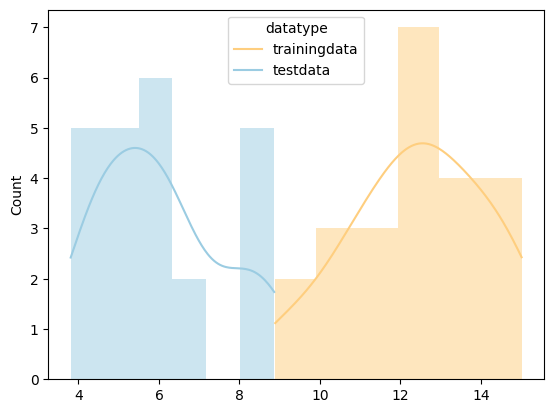

Using minmax scaler...


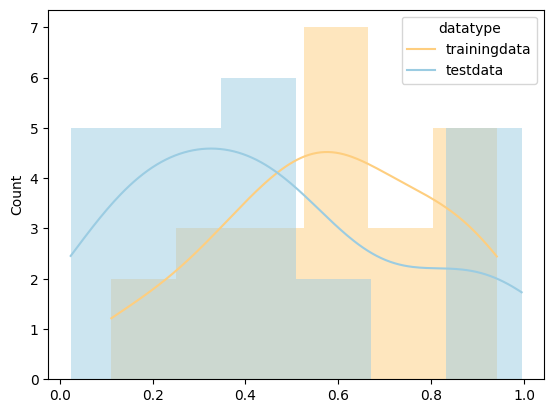

training data shape is  (5012, 23) 
test data shape is  (12, 23)
train model256 now


100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


train model512 now


100%|██████████| 128/128 [00:17<00:00,  7.45it/s]


train model1024 now


100%|██████████| 128/128 [00:17<00:00,  7.47it/s]

Training of Scaden is done


In [17]:
pred_Monaco_common = ScadenDeconvolution(sc_data, test_x_Monaco,
                                         generate_sim_method = "tape", add_noise = False, cut_variance= True, cell_type = "celltype",
                                         add_realdat=True, real_dat="/mnt/md0/yujia/project/github_package/demo/dat/bulk/PBMC/sdy_real_5ct.h5ad",
                                         markergene = common_genes)

Reading single-cell dataset, this may take 1 min
You are using H5AD format data, please make surecelltypeoccurs in the adata.obs
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


5000it [00:32, 154.29it/s]


Sampling is done
Reading training data
(5012, 11328)
        LINC00115         NOC2L       KLHL17     PLEKHN1          HES4  \
0     1883.710693  18727.172119  3011.874512    0.000000  12297.777100   
1      963.533157   9470.239014   263.643555  714.796326  18224.696777   
2     1895.862366  21022.344482     0.000000    0.000000   3872.275330   
3     2588.197998  20245.058350     0.000000    0.000000  18534.986877   
4     1983.804443  18321.361328   705.218628  612.745117   3163.929504   
...           ...           ...          ...         ...           ...   
5007     0.000000   4817.000000   500.000000  140.000000    277.000000   
5008     0.000000   5617.000000   495.000000  126.000000    311.000000   
5009     0.000000   4835.000000   509.000000   82.000000    596.000000   
5010     0.000000   4425.000000  1206.000000   86.000000    440.000000   
5011     0.000000   6451.000000   614.000000  148.000000    441.000000   

              ISG15     C1orf159      TNFRSF18       TNFRS

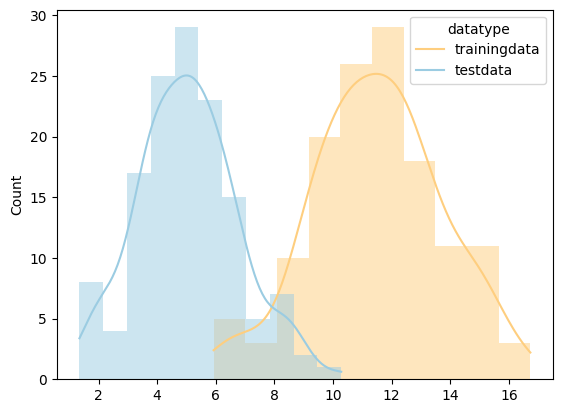

Using minmax scaler...


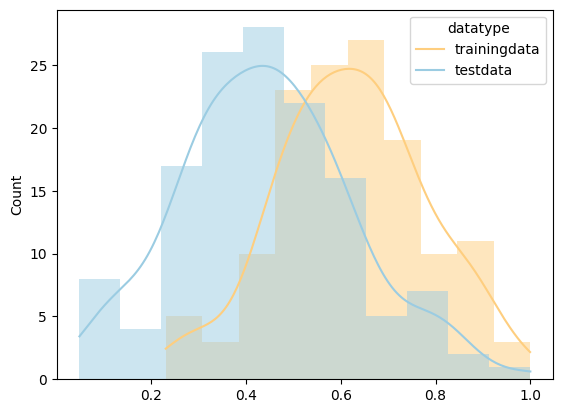

training data shape is  (5012, 136) 
test data shape is  (12, 136)
train model256 now


100%|██████████| 128/128 [00:16<00:00,  7.70it/s]


train model512 now


100%|██████████| 128/128 [00:17<00:00,  7.45it/s]


train model1024 now


100%|██████████| 128/128 [00:16<00:00,  7.57it/s]

Training of Scaden is done


In [18]:
pred_Monaco_all = ScadenDeconvolution(sc_data, test_x_Monaco,
                                         generate_sim_method = "tape", add_noise = False, cut_variance= True, cell_type = "celltype",
                                         add_realdat=True, real_dat="/mnt/md0/yujia/project/github_package/demo/dat/bulk/PBMC/sdy_real_5ct.h5ad",
                                         markergene = all_genes)

In [20]:
pred_Monaco_common

,B cells,CD4 T cells,CD8 T cells,Monocytes,NK cells
CYFZ,0.278812,0.130375,0.073973,0.347780,0.169061
FY2H,0.225955,0.067451,0.113997,0.527758,0.064840
FLWA,0.229178,0.115919,0.010878,0.505062,0.138963
453W,0.166888,0.221683,0.067234,0.310159,0.234036
684C,0.392340,0.188862,0.049953,0.302753,0.066092
CZJE,0.410252,0.087785,0.049330,0.339486,0.113147
925L,0.470408,0.044484,0.074030,0.314034,0.097044
9JD4,0.290829,0.195510,0.083328,0.336928,0.093406
G4YW,0.286574,0.110271,0.019070,0.467389,0.116696
4DUY,0.277574,0.279030,0.015449,0.360139,0.067807


In [21]:
pred_Monaco_all

,B cells,CD4 T cells,CD8 T cells,Monocytes,NK cells
CYFZ,0.106214,0.061005,0.551452,0.187984,0.093345
FY2H,0.075809,0.026869,0.402639,0.474566,0.020117
FLWA,0.080922,0.260251,0.164374,0.364441,0.130011
453W,0.047885,0.125868,0.526433,0.247088,0.052726
684C,0.116729,0.335733,0.282013,0.212465,0.053061
CZJE,0.169939,0.317255,0.206238,0.217237,0.089330
925L,0.182386,0.218364,0.239022,0.295853,0.064376
9JD4,0.062329,0.356888,0.259131,0.268567,0.053085
G4YW,0.075819,0.253385,0.137585,0.403167,0.130045
4DUY,0.071966,0.414171,0.130764,0.320624,0.062476


In [ ]:
# save results
pred_Monaco_all.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/res/10_simulation/PBMC/pbmcABC6K/Monaco/scaden_selected_genes_selected_genes_all.tsv", sep = "\t")
pred_Monaco_common.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/res/10_simulation/PBMC/pbmcABC6K/Monaco/scaden_selected_genes_selected_genes_common.tsv", sep = "\t")
